Analysis Report to Management - Apprentice Chef, Inc

# Introduction

Apprentice Chef, Inc. is a company that offers "daily-prepared gourmet meals delivered directly to your door”. Moreover, a cross-selling promotion, “Halfway There”, has been launched to bring local wines to subscribers.
To better understand their clientele, we have been provided with data of  ~2’000 active customers in their first year of purchases.



In [1]:
#INITIAL SETUP P1

#import all the packages needed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import statsmodels.formula.api as smf 
import sklearn.linear_model
from icecream import ic 
from sklearn.model_selection import train_test_split # train-test split
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from six import StringIO           # saves objects in memory
from IPython.display import Image                    # displays on frontend
import pydotplus                                     # interprets dot objects
from yellowbrick.classifier import ROCAUC
from pandas.plotting import parallel_coordinates
from collections import Counter
from yellowbrick.target import ClassBalance
import sklearn.preprocessing as preproc
from sklearn.ensemble import GradientBoostingClassifier # gbm
import sklearn.linear_model
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', None)

#importing the dataset
file = 'D:/Formazione/Hult/MSBA/2- Machine Learning/Assignment/Apprentice_Chef_Dataset.xlsx'

original_df = pd.read_excel(io = file)
df_work = original_df.copy()
df_work= df_work.rename(columns=str.lower)

#showing the dataset head
df_work.head(10)

#COEFFICIENTS GROUPING ['email']

#with the column 'first_name' it could have been possible to create a gender 
#guesser but the names are all archaic and not being able to find a proper training
#dataset, the model would be unuseful
#columns 'family_name', as previously explained, and 'name' (for similar 
#reasons)are not useful for the incoming models

#creating a dataset for the potential coefficients of the model and the output
X =['cross_sell_success', 'email','total_meals_ordered', 'unique_meals_purch',
    'contacts_w_customer_service','product_categories_viewed',
    'avg_time_per_site_visit','mobile_number', 'cancellations_before_noon',
    'cancellations_after_noon', 'tastes_and_preferences','pc_logins',
    'mobile_logins', 'weekly_plan', 'early_deliveries', 'late_deliveries',
    'package_locker','refrigerated_locker', 'avg_prep_vid_time',
    'largest_order_size', 'master_classes_attended', 'median_meal_rating',
    'avg_clicks_per_visit', 'total_photos_viewed']


#grouping the email domain
df_work[['name_mail','domain']] = df_work.email.str.split("@",expand=True)
df_work['domain'] = '@' + df_work['domain'].astype(str)
df_work = df_work.drop(columns = [ 'email', 'name_mail'])

#cheking the frequency of the mails
#print("\n\nfrequency of values in 'domain'\n\n", 
#      Counter(df_work['domain']))
##the only domains that may remain stand alone are  
# @gmail.com : 303 entries
# @protonmail.com: 284 entries
# @yahoo.com: 274 entries

#proceeding with the grouping according to the groups provided by the case
professional_list = ["@mmm.com", "@amex.com", "@apple.com", "@boing.com", 
                     "@caterpillar.com", "@chevron.com", "@cisco.com", 
                     "@cocacola.com", "@disney.com", "@dupont.com",
                     "@exxon.com", "@ge.org", "@goldmansacs.com", 
                     "@homedepot.com", "@ibm.com", "@intel.com","@jnj.com", 
                     "@jpmorgan.com", "@mcdonalds.com", "@merck.com", 
                     "@microsoft.com", "@nike.com", "@pfizer.com", 
                     "@pg.com", "@travelers.com", "@unitedtech.com", 
                     "@verizon.com", "@visa.com", "@walmart.com", 
                     "@unitedhealth.com", "@boeing.com"]

personal_list = ["@gmail.com", "@yahoo.com", "@protonmail.com"]
junk_list = ["@me.com", "@aol.com", "@hotmail.com", "@live.com", 
             "@msn.com", "@passport.com"]

for i in range(len(df_work)):
    domain_i = df_work.loc[i, 'domain']
    if domain_i in professional_list:
        df_work.loc[i, 'domain_group'] = "professional"
    elif domain_i in personal_list:
        df_work.loc[i, 'domain_group'] = "personal"
    elif domain_i in junk_list:
        df_work.loc[i, 'domain_group'] = "junk"
    else:
        df_work.loc[i, 'domain_group'] = "unknown"

#cheking the result
#print("\n\nfrequency of values in 'domain_group:|n ", 
#      Counter(df_work['domain_group']))


#GENDER GUESSER

#following 2 paths: gender.Detecor()_get_gender and the inclusion of an 
#external dataset (source: https://github.com/TheMLGuy/Game-of-Thrones-Dataset )


#gender.Detecor()
#in order to accelerate the process, the run of the code is in comment form
#(as reference) and the final result is hardcoded
#import gender_guesser.detector as gender # guess gender based on (given) name
# guessing gender based on (given) name
'''
# placeholder list
placeholder_lst = []

# looping to guess gender#
for name in df_work.loc[ : , 'first_name' ]:
    guess = gender.Detector().get_gender(name)
    print(guess)
    placeholder_lst.append(guess)

# converting list into a series
df_work['gender_guess'] = pd.Series(placeholder_lst)
'''
#the results of gender.Detector() are extremely poor with many unknowns, as
#expected given the names in the dataset


#external dataset
#in order to maintain this notebook standalone, the preprocessing of the 
#external file is in comment form (as a reference) and the final result is 
#hardcoded
"""
file = 'C:/Users/jacop/Desktop/character-predictions.xlsx'
got_genders = pd.read_excel(io = file, sheet_name = 'table')

#the values in the column 'male_average' are the averages of the dummy variable
#male for every name in order to have a best guess for every possible name.
#name + surname is not used to define the gender, despite the fact that it 
#would have led to an exact match. This because it would have been completely 
#unrealistic in a real world scenario

got_genders["male"] = 'unknown'
got_genders.loc[got_genders["male_average"] < 0.5, "male"] = 0
got_genders.loc[got_genders["male_average"] >= 0.5, "male"] = 1

attributed_gender = []
for i in df_work['first_name']:
    gender = got_genders.loc[got_genders['Names'] == i , 'male'].values
    attributed_gender.extend(gender)
    
# converting list into a series
df_work['got_gender'] = pd.Series(attributed_gender)

print(*attributed_gender, sep=", ")##
"""
#final result, sorted according to df_work
attributed_gender = [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1]

df_work['got_gender'] = pd.Series(attributed_gender)
df_work = df_work.drop(columns = [ 'first_name'])
#df_work.loc[ : , ['first_name' , 'got_gender'] ].head(30)
#a brief check show no missing values ('unknown') and a MOSTLY correct match


#HOT ENCODING - domain#

# one hot encoding categorical variables
domain_group_dummies = pd.get_dummies(df_work['domain_group'])

# dropping categorical variables after they've been encoded
df_work = df_work.drop('domain_group', axis = 1)
df_work = df_work.drop('domain', axis = 1)

# joining codings together
df_work = df_work.join(domain_group_dummies)


#VARIABLE AUGMENTATION

#NEW VARIABLES
for i in range(len(df_work)):
    df_work.loc[i,'name_lenght'] = len(df_work.loc[i,'name'])
    df_work.loc[i,'names_number'] = df_work.loc[i,'name'].count(" ")+1
df_work['late_percentage'] = df_work['late_deliveries'] / df_work['total_meals_ordered']
df_work['early_percentage'] = df_work['early_deliveries'] / df_work['total_meals_ordered']
df_work['early_or_late_percentage'] = (df_work['late_deliveries'] + df_work['early_deliveries']) / df_work['total_meals_ordered']
df_work['complains_per_order'] = df_work['contacts_w_customer_service'] / df_work['total_meals_ordered']
df_work['photos_per_order'] = df_work['total_photos_viewed'] / df_work['total_meals_ordered']
df_work['total_logins'] = df_work['pc_logins'] + df_work['mobile_logins']
df_work['order_per_login'] = df_work['total_meals_ordered'] / df_work['total_logins']
df_work['categories_per_login'] = df_work['product_categories_viewed'] / df_work['total_logins']
df_work['photos_per_login'] = df_work['total_photos_viewed'] / df_work['total_logins']
df_work['total_cancellations'] = df_work['cancellations_after_noon'] + df_work['cancellations_before_noon']
df_work['cancellations_per_order'] = df_work['total_cancellations'] + df_work['total_meals_ordered']

df_work['one_meal'] = 0
df_work.loc[df_work['unique_meals_purch'] == 1, 'one_meal'] = 1

#PAIRWISE INTERACTION FEATURES
#interactions= preproc.PolynomialFeatures(include_bias = False).fit_transform(df_work)


#DUMMIES WHERE THE TRENDS SEEM TO CHANGE
df_work['cancellations_before_noon_9'] = 0
df_work.loc[df_work['cancellations_before_noon'] >9,'cancellations_before_noon_9'] = 1

df_work['cancellations_before_noon_2to9'] = 0
df_work.loc[(df_work['cancellations_before_noon'] <9) & (df_work['cancellations_before_noon'] >2),
            'cancellations_before_noon_2to9'] = 1

df_work['total_cancellations_3'] = 0
df_work.loc[df_work['total_cancellations'] >3,'total_cancellations_3'] = 1

df_work['avg_prep_vid_time_mean'] = 0
df_work.loc[df_work['avg_prep_vid_time_mean'] >= np.mean(df_work['avg_prep_vid_time']),
            'avg_prep_vid_time_mean'] = 1

df_work['avg_clicks_per_visit_11'] = 0
df_work.loc[df_work['avg_clicks_per_visit'] >11,'avg_clicks_per_visit_11'] = 1

df_work['contacts_w_customer_service_10'] = 0
df_work.loc[df_work['contacts_w_customer_service'] >10,'contacts_w_customer_service_10'] = 1

df_work['pc_logins_6'] = 0
df_work.loc[df_work['pc_logins'] >6,'pc_logins_6'] = 1

df_work['mobile_logins_1'] = 0
df_work.loc[df_work['mobile_logins'] >1,'mobile_logins_1'] = 1

df_work['early_deliveries_4'] = 0
df_work.loc[df_work['early_deliveries'] >4,'early_deliveries_4'] = 1

df_work['largest_order_size_6'] = 0
df_work.loc[df_work['largest_order_size'] >6,'largest_order_size_6'] = 1

df_work['master_classes_attended_1'] = 0
df_work.loc[df_work['master_classes_attended'] >1,'master_classes_attended_1'] = 1

df_work['weekly_plan_15'] = 0
df_work.loc[(df_work['weekly_plan'] >0)  & (df_work['weekly_plan'] <15) ,'weekly_plan_15'] = 1

#INFERENCES OF THE TRENDS
df_work['cancellations_before_noon_9_val'] = df_work['cancellations_before_noon_9']*df_work['cancellations_before_noon']
df_work['cancellations_before_noon_2to9_val'] = df_work['cancellations_before_noon_2to9']*df_work['cancellations_before_noon']
df_work['total_cancellations_3_val'] = df_work['total_cancellations_3']*df_work['total_cancellations']
df_work['avg_prep_vid_time_mean_val'] = df_work['avg_prep_vid_time_mean']*df_work['avg_prep_vid_time']
df_work['avg_clicks_per_visit_11_val'] = df_work['avg_clicks_per_visit_11']*df_work['avg_clicks_per_visit']
df_work['contacts_w_customer_service_10_val'] = df_work['contacts_w_customer_service_10']*df_work['contacts_w_customer_service']
df_work['pc_logins_6_val'] = df_work['pc_logins_6']*df_work['pc_logins']
df_work['mobile_logins_1_val'] = df_work['mobile_logins_1']*df_work['mobile_logins']
df_work['early_deliveries_4_val'] = df_work['early_deliveries_4']*df_work['early_deliveries']
df_work['largest_order_size_6_val'] = df_work['largest_order_size_6']*df_work['largest_order_size']
df_work['master_classes_attended_1_val'] = df_work['master_classes_attended_1']*df_work['master_classes_attended']
df_work['weekly_plan_15_val'] = df_work['weekly_plan_15']*df_work['weekly_plan']

#to avoid log(0) -> -inf we ad a small value to avoid the presence of 0 
#in an efficient way
eps = 0.0000000001

#CONTINUOUS - log
df_work['avg_time_per_site_visit_log'] = np.log10(df_work["avg_time_per_site_visit"]+ eps)
df_work['avg_prep_vid_time_log'] = np.log10(df_work["avg_prep_vid_time"]+ eps)
df_work['total_meals_ordered_log'] = np.log10(df_work["total_meals_ordered"]+ eps)

#INTERVAL/COUNT - log
df_work['cancellations_before_noon_log'] = np.log10(df_work["cancellations_before_noon"]+ eps)
df_work['cancellations_after_noon_log'] = np.log10(df_work["cancellations_after_noon"]+ eps)
df_work['weekly_plan_log'] = np.log10(df_work["weekly_plan"]+ eps)
df_work['early_deliveries_log'] = np.log10(df_work["early_deliveries"]+ eps)
df_work['late_deliveries_log'] = np.log10(df_work["late_deliveries"]+ eps)
df_work['largest_order_size_log'] = np.log10(df_work["largest_order_size"]+ eps)
df_work['master_classes_attended_log'] = np.log10(df_work["master_classes_attended"]+ eps)
df_work['total_photos_viewed_log'] = np.log10(df_work["total_photos_viewed"]+ eps)
df_work['revenue_log'] = np.log10(df_work["revenue"]+ eps)


#INTERVAL/COUNT - 1/0
df_work['cancellations_before_noon_dummy'] = 0 
df_work.loc[df_work['cancellations_before_noon'] > 0, 
            'cancellations_before_noon_dummy'] = 1

df_work['cancellations_after_noon_dummy'] = 0
df_work.loc[df_work['cancellations_after_noon'] > 0, 
            'cancellations_after_noon_dummy'] = 1

df_work['weekly_plan_dummy'] = 0
df_work.loc[df_work['weekly_plan'] > 0, 
            'weekly_plan_dummy'] = 1

df_work['early_deliveries_dummy'] = 0
df_work.loc[df_work['early_deliveries'] > 0, 
            'early_deliveries_dummy'] = 1

df_work['late_deliveries_dummy'] = 0
df_work.loc[df_work['late_deliveries'] > 0, 
            'late_deliveries_dummy'] = 1

df_work['master_classes_attended_dummy'] = 0
df_work.loc[df_work['master_classes_attended'] > 0, 
            'master_classes_attended_dummy'] = 1

df_work['total_photos_viewed_dummy'] = 0
df_work.loc[df_work['total_photos_viewed'] > 0, 
            'total_photos_viewed_dummy'] = 1

#INTERVAL/COUNT - merging
df_work['cancellations_dummy'] = 0
df_work.loc[(df_work['cancellations_after_noon'] * df_work['cancellations_before_noon']) > 0, 
            'cancellations_dummy'] = 1

df_work['early_or_late_deliveries_dummy'] = 0
df_work.loc[(df_work['early_deliveries'] * df_work['late_deliveries'] > 0), 
            'early_or_late_deliveries_dummy'] = 1

df_work['early_delivery_with_refrigerated_dummy'] = df_work['early_deliveries'] * df_work['refrigerated_locker']
df_work['late_delivery_with_refrigerated_dummy'] = df_work['late_deliveries'] * df_work['refrigerated_locker']

df_work['early_delivery_with_refrigerated'] = df_work['early_deliveries'] * df_work['refrigerated_locker']
df_work['late_delivery_with_refrigerated'] = df_work['late_deliveries'] * df_work['refrigerated_locker']

df_work['early_delivery_with_locker_dummy'] = df_work['early_deliveries'] * df_work['package_locker']
df_work['late_delivery_with_locker_dummy'] = df_work['late_deliveries'] * df_work['package_locker']

df_work['early_delivery_with_locker'] = df_work['early_deliveries'] * df_work['package_locker']
df_work['late_delivery_with_locker'] = df_work['late_deliveries'] * df_work['package_locker']


#CHECK
#dropping columns name and family name since we won't use them
df_work = df_work.drop(columns = ['name', 'family_name'])
#print(df_work.columns)

In [2]:
#INITIAL SETUP P2
#TRAIN AND TEST SPLIT FOR REGRESSION
# preparing explanatory variable data
X_reg   = df_work.drop(['revenue','revenue_log'],
                                axis = 1)

# preparing response variable data
Y_reg = df_work.loc[ : , 'revenue']



# preparing training and testing sets (all letters are lowercase)
x_reg_train, x_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg,Y_reg,
                                                    test_size = 0.25,
                                                    random_state = 219)
        

y_reg_log_train = np.log10(y_reg_train)
y_reg_log_test = np.log10(y_reg_test)



#TRAIN_TEST SPLIT for CLASSIFICATION

X_class = df_work.drop(columns = "cross_sell_success")
Y_class = df_work.loc[:, "cross_sell_success"]

# train-test split with stratification
x_class_train, x_class_test, y_class_train, y_class_test = train_test_split(
            X_class,
            Y_class,
            test_size    = 0.25,
            random_state = 219,
            stratify     = Y_class)



# Models

## Revenue Model
To predict revenues per customer.

R-squared = 0.809.

In [3]:
#REVENUE MODEL

#in the following list there are stored the erased features due to their too
#high p-values
eliminated_for_p = ['avg_clicks_per_visit','cancellations_after_noon',
                  'early_delivery_with_refrigerated_dummy', 
                  'early_delivery_with_refrigerated', 'refrigerated_locker',
                 'early_percentage', 'early_or_late_percentage', 'cancellations_dummy',
                 'order_per_login', 'pc_logins_6_val', 'pc_logins_6', 'late_deliveries_dummy',
                 'unique_meals_purch', 'largest_order_size_6_val', 'largest_order_size_6',
                 'total_photos_viewed', 'photos_per_login', 'avg_prep_vid_time_log',
                 'weekly_plan', 'cancellations_after_noon_log', 'cancellations_after_noon_dummy',
                 'tastes_and_preferences', 'contacts_w_customer_service_10',
                 'late_delivery_with_refrigerated', 'late_delivery_with_refrigerated_dummy',
                 'mobile_logins', 'mobile_logins_1', 'pc_logins', 'mobile_logins_1_val',
                 'total_logins', 'product_categories_viewed', 'package_locker',
                 'early_deliveries_4', 'early_deliveries', 'early_deliveries_4_val',
                  'early_deliveries_log', 'complains_per_order', 'avg_time_per_site_visit',
                  'total_meals_ordered', 'late_deliveries', 'late_percentage',
                  'mobile_number', 'got_gender', 'weekly_plan_15', 'weekly_plan_log',
                  'weekly_plan_15_val', 'early_delivery_with_locker_dummy',
                  'early_delivery_with_locker', 'cancellations_before_noon_dummy',
                  'cancellations_before_noon_log', 'cancellations_before_noon',
                  'early_deliveries_dummy', 'late_deliveries_log', 'weekly_plan_dummy',
                  'late_delivery_with_locker_dummy', 'late_delivery_with_locker',
                  'avg_clicks_per_visit_11_val','cancellations_per_order',
                   'avg_prep_vid_time_mean','avg_prep_vid_time_mean_val']

#after removing the factors with too high p-values, it follows the lists of
#redundant variables (ex: x, log(x))
#this created a ripple effect on new variables that increased their p-values
#and became unconsistent with the model
eliminated_for_redundancy = ['largest_order_size','master_classes_attended',
                            'master_classes_attended_1', 'personal', 
                             'master_classes_attended_log', 'professional',
                            'junk', 'master_classes_attended_1_val', 
                             'early_or_late_deliveries_dummy']

#LINEAR REGRESSION MODEL - 2  [CHOOSEN MODEL]

#removing the dropped columns according to the previous model
x_train_OLS_2_p =  x_reg_train.drop(columns = eliminated_for_p)
x_test_OLS_2_p =  x_reg_test.drop(columns = eliminated_for_p)
x_train_OLS_2 =  x_train_OLS_2_p.drop(columns = eliminated_for_redundancy)
x_test_OLS_2 =  x_test_OLS_2_p.drop(columns = eliminated_for_redundancy)


# INSTANTIATING a model object
lr_2 = LinearRegression()

# FITTING to the training data
lr_2_fit = lr_2.fit(x_train_OLS_2, y_reg_log_train)

# PREDICTING on new data
lr_2_pred = lr_2_fit.predict(x_test_OLS_2)

print('\033[1m'+'\033[94m' +" REVENUE MODEL"+'\033[0m',"\n\n")

# SCORING the results
print("PERFORMANCES\n")
print('\033[1m' +'Training Score : '+ '\033[0m',":", end= " ")
print( lr_2.score(x_train_OLS_2, y_reg_log_train).round(3))  # using R-square
print('\033[1m' +'Testing Score  : '+ '\033[0m',":", end= " ")
print( lr_2.score(x_test_OLS_2, y_reg_log_test).round(3)) # using R-square

lr_2_train_score = lr_2.score(x_train_OLS_2, y_reg_log_train).round(3)
lr_2_test_score  = lr_2.score(x_test_OLS_2, y_reg_log_test).round(3)

# displaying and saving the gap between training and testing
print('\033[1m' +'Train-Test Gap : '+ '\033[0m',":", end= " ")
print( abs(lr_2_train_score - lr_2_test_score).round(3))
lr_2_test_gap = abs(lr_2_train_score - lr_2_test_score).round(3)


print("\n\n")
# zipping each feature name to its coefficient
lr_2_model_values = zip(x_reg_train.columns,
                      lr_2_fit.coef_.round(decimals = 3))


# setting up a placeholder list to store model features
lr_2_model_lst = [('intercept', lr_2_fit.intercept_.round(decimals = 3))]

# printing out each feature-coefficient pair one by one
for val in lr_2_model_values:
    lr_2_model_lst.append(val)
    
print("COEFFICIENTS (sorted)\n")
for i in sorted(lr_2_model_lst, key=lambda x: x[1], reverse = True):
    print('\033[1m' +i[0]+ '\033[0m',":", end= " ")
    if i[1] >= 0:
        print('\033[32m'+"+"+str(i[1])+ '\033[0m')
    elif i[1] < 0:
        print('\033[31m'+str(i[1])+ '\033[0m')
    else:
        print("something went wrong")
        


 REVENUE MODEL 


PERFORMANCES

Training Score :  : 0.809
Testing Score  :  : 0.802
Train-Test Gap :  : 0.007



COEFFICIENTS (sorted)

intercept : +2.921
tastes_and_preferences : +0.257
master_classes_attended : +0.16
largest_order_size : +0.05
contacts_w_customer_service : +0.048
avg_clicks_per_visit : +0.048
total_photos_viewed : +0.038
total_meals_ordered : +0.023
weekly_plan : +0.014
late_deliveries : +0.012
package_locker : +0.011
cancellations_before_noon : +0.008
avg_time_per_site_visit : +0.002
unique_meals_purch : +0.001
product_categories_viewed : +0.001
pc_logins : +0.001
mobile_number : -0.002
cancellations_after_noon : -0.002
refrigerated_locker : -0.005
cross_sell_success : -0.015
mobile_logins : -0.02
avg_prep_vid_time : -0.02
early_deliveries : -0.032
median_meal_rating : -0.053
got_gender : -0.547


## Cross-Sell Success Model
To predict if a customer will subscribe to the cross-selling campaign. 

AUC score = 0.833.

In [4]:
#CROSS-SELL SUCCESS MODEL

#BOOST MODEL SKLEARN - TUNED [CHOOSEN MODEL]

x_gbm_train =x_class_train
x_gbm_test = x_class_test

# INSTANTIATING a random forest model with default values
gbm = GradientBoostingClassifier(n_estimators = 140, max_depth = 2, 
                                 loss = 'exponential', learning_rate = 0.4,
                                 criterion = 'friedman_mse',random_state  = 219)

# FITTING the training data
gbm_fit = gbm.fit(X_class,Y_class)


# PREDICTING on new data
gbm_pred = gbm_fit.predict(x_gbm_test)


print('\033[1m'+'\033[94m' +" CROSS-SELL SUCCESS MODEL"+'\033[0m',"\n\n")



# SCORING the model
print("PERFORMANCES\n")
print('\033[1m' +'Training Accuracy : '+ '\033[0m',":", end= " ")
gbm_train_score = gbm_fit.score(x_gbm_train, y_class_train).round(3)
print(gbm_train_score)
print('\033[1m' +'Testing Accuracy : '+ '\033[0m',":", end= " ")
gbm_test_score = gbm_fit.score(x_gbm_test, y_class_test).round(3)
print(gbm_test_score)
# displaying and saving the gap between training and testing
print('\033[1m' +'Train-Test Gap : '+ '\033[0m',":", end= " ")
print(abs(gbm_train_score - gbm_test_score).round(3))
gbm_test_gap = abs(gbm_train_score - gbm_test_score).round(3)
print('\033[1m' +'AUC Score : '+ '\033[0m',":", end= " ")
print(roc_auc_score(y_true  = y_class_test, y_score = gbm_pred).round(3))


#TREE MODEL RESULTS

# unpacking the confusion matrix
gbm_tn, \
gbm_fp, \
gbm_fn, \
gbm_tp = confusion_matrix(y_true = y_class_test, y_pred = gbm_pred).ravel()


# printing each result one-by-one
print("\n\nCONFUSION MATRIX\n")
print('\033[1m' +"True Negatives : " +'\033[0m', gbm_tn)
print('\033[1m' +"False Positives : " +'\033[0m', gbm_fp)
print('\033[1m' +"False Negatives : " +'\033[0m', gbm_fn)
print('\033[1m' +"True Positives : " +'\033[0m', gbm_tp)


 CROSS-SELL SUCCESS MODEL 


PERFORMANCES

Training Accuracy :  : 0.869
Testing Accuracy :  : 0.879
Train-Test Gap :  : 0.01
AUC Score :  : 0.833


CONFUSION MATRIX

True Negatives :  110
False Positives :  46
False Negatives :  13
True Positives :  318


# Insights

## Reduce the complaints
Contacts with customer service are positively correlated to revenues, but after a certain level (10 contacts), revenues drop.

This means that even though customer care usually solves eventual issues (that's why first calls don't reduce revenues), it's important to decrease the complaints per capita to not exhaust and lose customers.

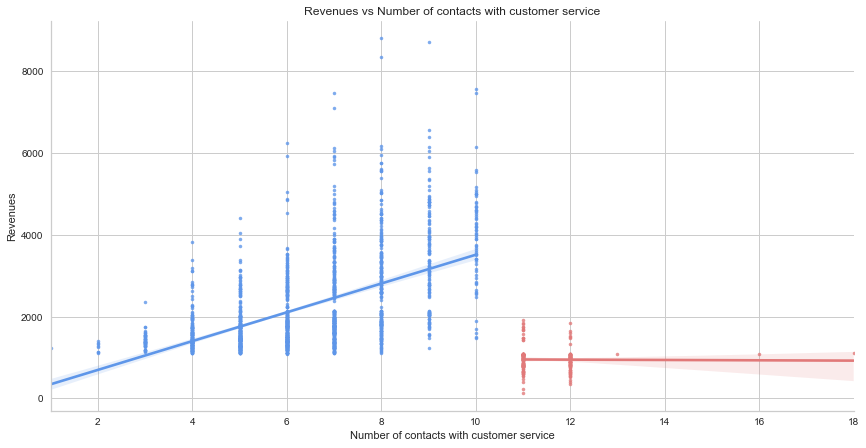

In [5]:
#Reduce the complaints plot

sns.lmplot( x ="contacts_w_customer_service" , y = "revenue", 
           hue = 'contacts_w_customer_service_10', palette = ['#5E96E9','#E17979'], 
           order = 1, data = df_work, legend=False,height = 6,aspect = 2, 
           markers='.' )
plt.xlabel("Number of contacts with customer service")
plt.ylabel("Revenues")
plt.title("Revenues vs Number of contacts with customer service")
plt.show()


## Educate the customers
Revenues  benefit from an increase in complexity of the meals (related to the length of the preparation videos) and masterclass attendance. Customers seem to appreciate the skills learned and repay with loyalty and so it's important to continue increasing the quality of food and services provided.  


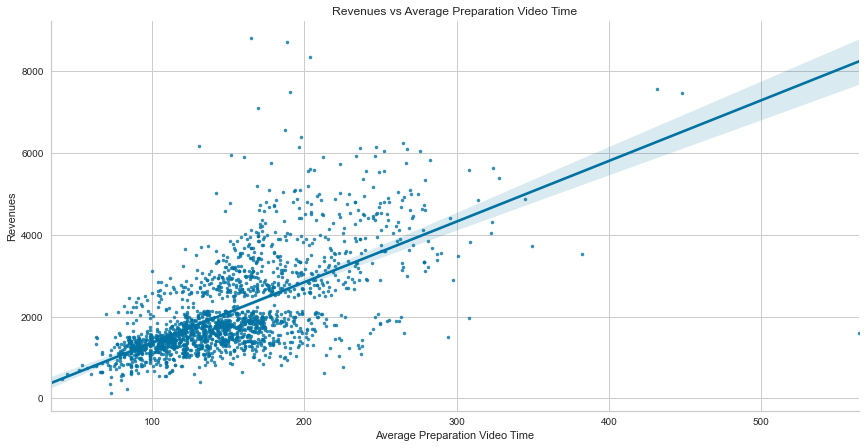

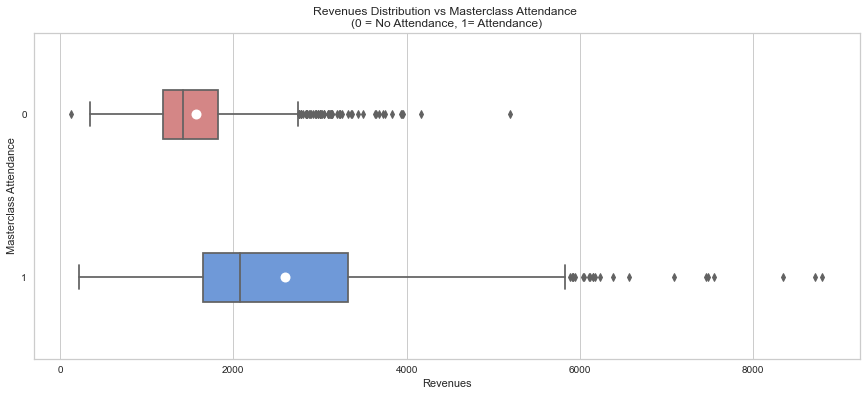

In [6]:
#Educate the customer plots
sns.lmplot( x ="avg_prep_vid_time" , y = "revenue", 
            palette = ['#5E96E9','#E17979'],markers='.', order = 1, data = df_work, 
           legend=False,height = 6,aspect = 2)
plt.title('Revenues vs Average Preparation Video Time')
plt.ylabel('Revenues')
plt.xlabel('Average Preparation Video Time')
plt.show()

plt.figure(figsize=(14.8, 6))
sns.boxplot(x="revenue", y="master_classes_attended_dummy", 
            orient="h", data=df_work, width=.3, palette=['#E17979','#5E96E9'],
            showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", 
            "markeredgecolor":"white","markersize":"10"})
plt.title('Revenues Distribution vs Masterclass Attendance \n(0 = No Attendance, 1= Attendance)')
plt.xlabel('Revenues')
plt.ylabel('Masterclass Attendance')
plt.show()

## The most receptive customers give more informations
A positive correlation between the number of words in the name and the enrollment in the cross-sell campaign, may indicate that a more complete profile (that contains name and surname) is a sign of inclination to participate in promotions. Therefore, the suggestion is to gently push the customers in completing their profiles and focus campaigns on customers with complete profiles. 

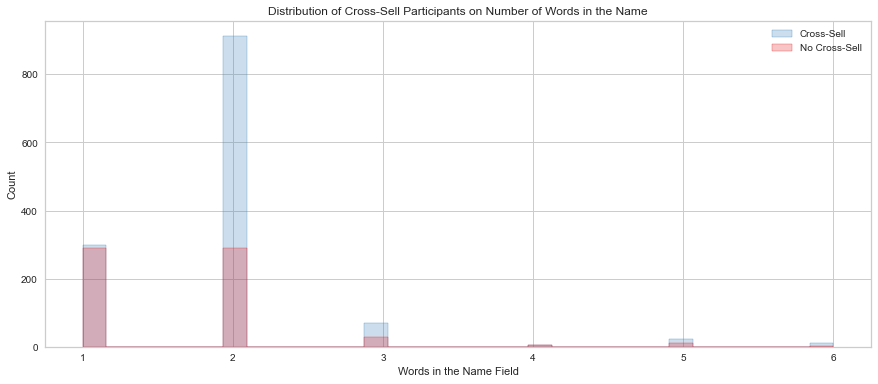

In [7]:
#The most receptive ones gives more information

plt.figure(figsize=(14.8, 6))
sns.histplot(data=df_work, x="names_number", hue="cross_sell_success",element="step",
             stat="count",palette = "Set1", common_norm=False)

plt.legend(["Cross-Sell", "No Cross-Sell"])
plt.title("Distribution of Cross-Sell Participants on Number of Words in the Name")
plt.xlabel('Words in the Name Field')
plt.show()


## Quality of the email = Quality of the customer
A significant difference in the cross-sell participation is clear between "junk" emails  and all others. It may be explainable with the behavior of customers of providing secondary emails for services they are not interested in. The quality of the domains must be seen as an indicator of the quality of the customer and considered in advertising and lead-evaluation. 

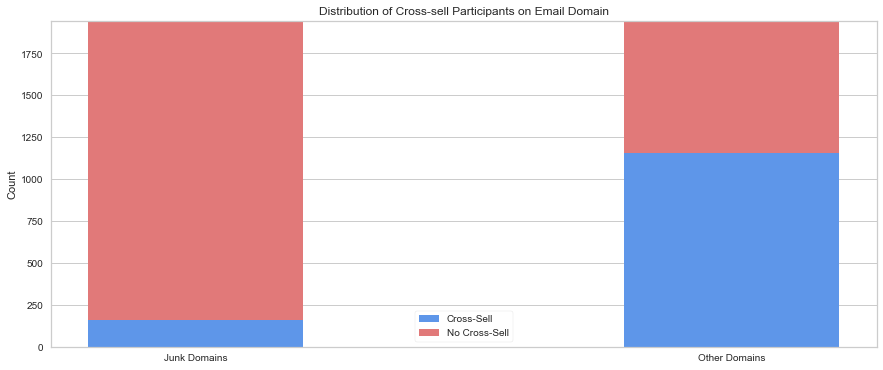

In [8]:
#quality of the email = quality of the customer plot

junk_1_0 = [sum(df_work.loc[df_work["junk"]==1, "cross_sell_success"]), len(df_work["junk"])-sum(df_work.loc[df_work["junk"]==1, "cross_sell_success"])]
other_1_0 = [sum(df_work.loc[df_work["junk"]==0, "cross_sell_success"]), len(df_work["junk"])-sum(df_work.loc[df_work["junk"]==0, "cross_sell_success"])]

#plt.bar("1", height = sum(junk_1_0))
plt.figure(figsize=(14.8, 6))
plt.bar(["Junk Domains", "Other Domains"], height = [junk_1_0[0], other_1_0[0]],
       color = '#5E96E9', width= 0.4)
plt.bar(["Junk Domains", "Other Domains"], height = [junk_1_0[1], other_1_0[1]], 
        bottom = [junk_1_0[0], other_1_0[0]],color = '#E17979', width= 0.4 )
plt.ylim([0, 1946])
legend_label = ['Cross-Sell', 'No Cross-Sell']
plt.legend(legend_label, frameon = True)
plt.title("Distribution of Cross-sell Participants on Email Domain")
plt.ylabel('Count')
plt.show()
